In [42]:
from Bio.PDB import *
import numpy as np
import pandas as pd

def get_alpha_carbons(structure):
    """
    Extract alpha carbon atoms from a structure.
    """
    alpha_carbons = []
    for model in structure:
        for chain in model:
            for residue in chain:
                if is_aa(residue):
                    try:
                        alpha_carbon = residue['CA']
                        res_name = residue.get_resname()
                        res_num = residue.get_id()[1]
                        chain_id = chain.get_id()
                        alpha_carbons.append((alpha_carbon, res_name, res_num, chain_id))
                    except KeyError:
                        continue
    return alpha_carbons

def calculate_distance(atom1, atom2):
    """
    Calculate Euclidean distance between two atoms.
    """
    return np.linalg.norm(atom1.coord - atom2.coord)

def get_residue_pairs_distances(pdb_file):
    """
    Calculate distances between all residue pairs in a PDB file.
    """
    parser = PDBParser()
    structure = parser.get_structure('structure', pdb_file)
    alpha_carbons = get_alpha_carbons(structure)
    distances = []
    for i, (atom1, res_name1, res_num1, chain1) in enumerate(alpha_carbons):
        for j, (atom2, res_name2, res_num2, chain2) in enumerate(alpha_carbons):
            if i < j:
                distances.append((res_name1, res_num1, chain1, res_name2, res_num2, chain2, calculate_distance(atom1, atom2)))
    return distances

def calculate_difference(distances1, distances2):
    """
    Calculate difference between two sets of distances.
    """
    diff = []
    for dist1, dist2 in zip(distances1, distances2):
        diff.append((dist1[0], dist1[1], dist1[2], dist1[3], dist1[4], dist1[5], dist1[6], dist2[6], dist2[6] - dist1[6]))
    return diff

def main(pdb_file1, pdb_file2, cutoff):
    """
    Main function to calculate distances and differences.
    """
    distances1 = get_residue_pairs_distances(pdb_file1)
    distances2 = get_residue_pairs_distances(pdb_file2)

    difference = calculate_difference(distances1, distances2)

    df = pd.DataFrame(difference, columns=['Residue1_Name', 'Residue1_Num', 'Residue1_Chain', 'Residue2_Name', 'Residue2_Num', 'Residue2_Chain', 'Distance_PDB1', 'Distance_PDB2', 'Difference'])
    df.to_csv('residue_pairs_difference.csv', index=False)
    
    # Filter rows based on absolute difference exceeding cutoff
    filtered_df = df[abs(df['Difference']) > cutoff_diff]
    if not filtered_df.empty:
        # Sort by absolute difference from largest to smallest
        filtered_df = filtered_df.sort_values(by='Difference', key=abs, ascending=False)
        filtered_df.to_csv(f'residue_pairs_difference_cutoff_diff-{cutoff_diff}A.csv', index=False)
    else:
        print("No rows exceed the difference cutoff.")

if __name__ == "__main__":
    pdb_file1 = "pqrse_65_noMQ8.pdb"
    pdb_file2 = "pqrse_67_noMQ8.pdb"
    cutoff = 7.0  # You can change the cutoff value as needed
    cutoff_diff = 2.0 
    main(pdb_file1, pdb_file2, cutoff)

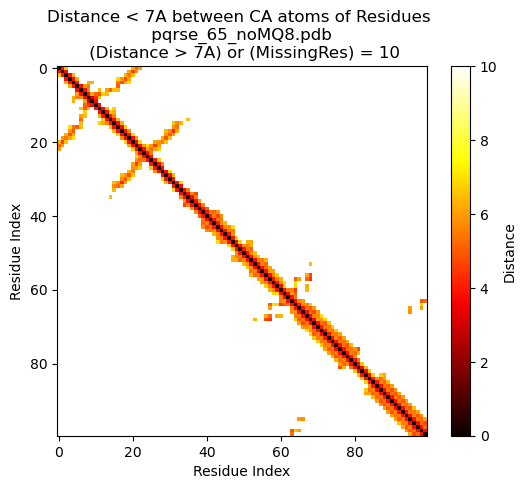

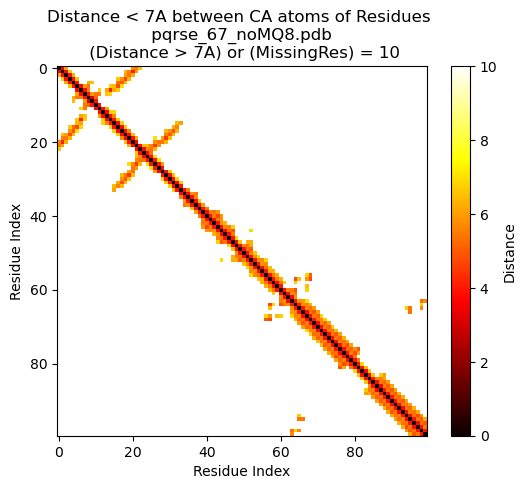

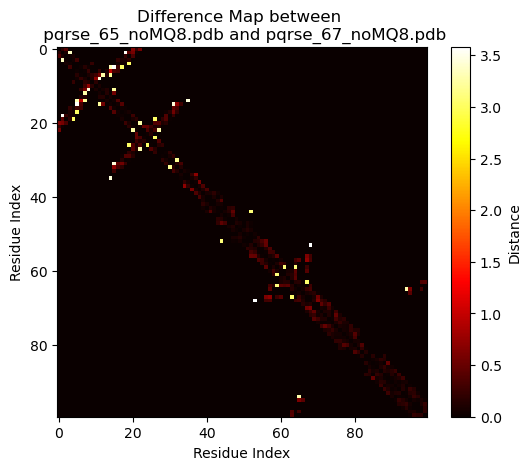

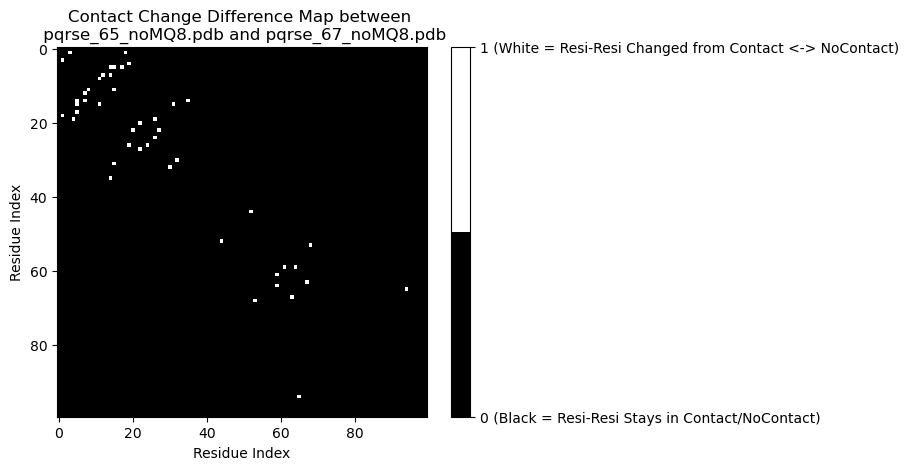

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from Bio.PDB import PDBParser

# CA-CA For AlphaHelix H-Bond ~ 6.1A (Tested with Leu7-Leu11 Chain P, Resi 7 to Resi11)
# Provide the path to your PDB file, Ensure to remove HETATMS before running
pdb_file1 = 'pqrse_65_noMQ8.pdb'
pdb_file2 = 'pqrse_67_noMQ8.pdb'

# Define the distance cutoff
distance_cutoff = 7

def calculate_distance(atom1, atom2):
    """
    Calculate the Euclidean distance between two atoms.
    """
    return np.linalg.norm(atom1.coord - atom2.coord)

def create_distance_matrix(pdb_file, distance_cutoff=10.0):
    """
    Create a distance matrix for all residues in the provided PDB file
    with distances below the given cutoff.
    """
    # Parse the PDB file
    parser = PDBParser()
    structure = parser.get_structure('pdb', pdb_file)
    
    # Get number of residues
    num_residues = len(list(structure.get_residues()))
    

    # Initialize distance matrix
    distance_matrix = np.zeros((num_residues, num_residues))
    contact_matrix = np.zeros((num_residues, num_residues))

    # Iterate over all residues
    for i, residue1 in enumerate(structure.get_residues()):
        for j, residue2 in enumerate(structure.get_residues()):
            # Calculate distance between CA atoms of residues
            try:
                atom1 = residue1['CA']
                atom2 = residue2['CA']
                dist = calculate_distance(atom1, atom2)
                if dist <= distance_cutoff:
                    distance_matrix[i, j] = dist
                    contact_matrix[i, j] = 1
                else:
                    # If distance too large, set distance to 10 and contact to 0
                    distance_matrix[i, j] = distance_cutoff + 3 
                    contact_matrix[i, j] = 0
            except KeyError:
                # If CA atom is missing, set distance to 10 and contact to 0
                distance_matrix[i, j] = distance_cutoff + 3 
                contact_matrix[i, j] = 0

    return distance_matrix, contact_matrix

def plot_heatmap(distance_matrix, pdb_file, Res_min, Res_max):
    pdb_file = pdb_file
    distance_matrix = distance_matrix[Res_min:Res_max, Res_min:Res_max]
    fig, ax = plt.subplots()
    im = ax.imshow(distance_matrix, cmap='viridis')
    plt.imshow(distance_matrix, cmap='hot', origin='upper', interpolation='nearest')
    plt.xlabel('Residue Index')
    plt.ylabel('Residue Index')
    plt.colorbar(label='Distance')
    plt.title(f'Distance < {distance_cutoff}A between CA atoms of Residues \n {pdb_file} \n (Distance > {distance_cutoff}A) or (MissingRes) = 10')
    plt.show()
    
def plot_diffmap(diff_matrix, Res_min, Res_max):
    diff_matrix = diff_matrix[Res_min:Res_max, Res_min:Res_max]
    fig, ax = plt.subplots()
    im = ax.imshow(diff_matrix, cmap='viridis')
    plt.imshow(diff_matrix, cmap='hot', origin='upper', interpolation='nearest')
    plt.xlabel('Residue Index')
    plt.ylabel('Residue Index')
    plt.colorbar(label='Distance')
    plt.title(f'Difference Map between \n {pdb_file1} and {pdb_file2}')
    plt.show()

def plot_contact_diffmap(diff_matrix, Res_min, Res_max):
    diff_matrix = diff_matrix[Res_min:Res_max, Res_min:Res_max]
    colors = [(0, 0, 0), (1, 1, 1)]  # Black to white custom colormap
    custom_cmap = plt.cm.colors.LinearSegmentedColormap.from_list('custom_cmap', colors, N=2)
    fig, ax = plt.subplots()
    im = ax.imshow(diff_matrix, cmap=custom_cmap, origin='upper', interpolation='nearest')
    cbar = plt.colorbar(im, ticks=[0, 1])
    cbar.ax.set_yticklabels(['0 (Black = Resi-Resi Stays in Contact/NoContact)', '1 (White = Resi-Resi Changed from Contact <-> NoContact)'])
    plt.xlabel('Residue Index')
    plt.ylabel('Residue Index')
    plt.title(f'Contact Change Difference Map between \n {pdb_file1} and {pdb_file2}')
    plt.show()    
    
# Create distance matrix with distance cutoff
distance_matrix1, contact_matrix1 = create_distance_matrix(pdb_file1, distance_cutoff)
distance_matrix2, contact_matrix2 = create_distance_matrix(pdb_file2, distance_cutoff)
distance_matrix_diff = np.abs(distance_matrix2 - distance_matrix1)
contact_matrix_diff  = np.abs(contact_matrix2 - contact_matrix1)

# Plot heatmap
Res_min, Res_max = 0, 100 #distance_matrix1.shape[0]
plot_heatmap(distance_matrix1, pdb_file1, Res_min, Res_max)
plot_heatmap(distance_matrix2, pdb_file2, Res_min, Res_max)
plot_diffmap(distance_matrix_diff, Res_min, Res_max)
plot_contact_diffmap(contact_matrix_diff, Res_min, Res_max)